# 03 forward plots
Making forward plots to verify reasonable spectra predictions for data augmentation

In [36]:
import pandas as pd
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle

from rdkit import Chem
from rdkit.Chem import Draw

In [2]:

import mist.utils  as utils
from mist.utils import plot_utils

plot_utils.set_style()

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
input_dir = "../data/paired_spectra/canopus_train/"
input_dir = Path(input_dir)
forward_folder = input_dir / "morgan4096_spec_preds_fold_100_0"
labels_file = input_dir / "labels.tsv"
k = 6
date = datetime.now().strftime("%Y_%m_%d")
res_dir = f"../results/{date}_output_forward_imgs"
res_dir_orig = Path(res_dir)
res_dir_orig.mkdir(exist_ok=True)

In [ ]:
full_labels = pd.read_csv(labels_file, sep="\t")
forward_labels_file = forward_folder / "labels.tsv"
forward_labels = pd.read_csv(forward_labels_file, sep="\t", index_col=0)

In [ ]:
name_to_full_smi = dict(full_labels[['spec', 'smiles']].values)
name_to_forward_smi = dict(forward_labels[['spec', 'smiles']].values)

name_to_full_ikey = dict(full_labels[['spec', 'inchikey']].values)
name_to_forward_ikey = dict(forward_labels[['spec', 'inchikey']].values)

ikey_to_forward = dict(forward_labels[['inchikey', 'spec']].values)
ikey_to_spec = dict(full_labels[['inchikey', 'spec']].values)
print(len(ikey_to_forward.keys()))
print(len(ikey_to_spec.keys()))

In [ ]:
ikeys_forward = set(ikey_to_forward.keys())
ikeys_full = set(ikey_to_spec.keys())
ikey_overlap = ikeys_full.intersection(ikeys_forward)
print("Len of overlap", len(ikey_overlap))


In [ ]:
split_file = "../data/paired_spectra/canopus_train/splits/canopus_hplus_100_0.csv"
split_df = pd.read_csv(split_file,)
split_df_test_names = split_df[split_df['Fold_100_0'] == "test"]
split_df_train_names = split_df[split_df['Fold_100_0'] == "train"]

test_names = split_df_test_names['name'].values
train_names = split_df_train_names['name'].values
test_ikeys = [name_to_full_ikey[i] for i in test_names]
train_ikeys = [name_to_full_ikey[i] for i in train_names]
print(len(ikey_overlap.intersection(train_ikeys)), len(train_ikeys))
print(len(ikey_overlap.intersection(test_ikeys)), len(test_ikeys))

In [ ]:
# Sample forward ikey
test_name = np.random.choice(test_names)
test_ikey = name_to_full_ikey[test_name]
sample_spec = ikey_to_forward[test_ikey]
# sample_spec = np.random.choice(forward_labels['spec'].values)
sample_compound = name_to_forward_smi[sample_spec]
print(sample_compound)
Chem.MolFromSmiles(sample_compound)

In [ ]:
pred_file = forward_folder / "spectra" / f"{sample_spec}.tsv"
spec = pd.read_csv(pred_file, sep="\t", index_col=0)

In [ ]:
sirius_df = forward_folder.parent / "sirius_outputs/summary_statistics/summary_df.tsv"
sirius_df = pd.read_csv(sirius_df, sep="\t", index_col=0)
real_spec = forward_folder.parent / "spec_files" / f"{test_name}.ms"

spec_name_to_sirius = dict(sirius_df[['spec_name', "spec_file"]].values)
real_spec = spec_name_to_sirius[test_name]
real_df = pd.read_csv(Path("../") / real_spec, sep="\t")
mzs, intens = real_df[['mz', "rel.intensity"]]
#real_spec 

In [ ]:
# spec_ar = utils.parse_spectra(real_spec)[1][0][1]
# spec_ar = np.array([j for j in sorted(spec_ar, key = lambda x : x[1])][-20:])
# spec_ar[:, 1] = spec_ar[:, 1] /  spec_ar[:, 1].max()
# mzs, intens = spec_ar[:, 0], spec_ar[:, 1]
fig = plt.figure(figsize=(3.5,1.7), dpi=300)
ax = fig.gca()
for ind, (m, i) in enumerate(zip(mzs, intens)): 
    ax.vlines(x=m, ymin=0,ymax=i, color="black", linewidth=0.5)
ax.set_xlabel("M/Z")
ax.set_ylabel("Intensity")
ax.set_ylim([0,1.2])
print(sample_compound)

In [ ]:
mzs, intens = zip(*spec[["mz", "intensity"]].values)
fig = plt.figure(figsize=(3.5,1.7), dpi=300)
ax = fig.gca()
for ind, (m, i) in enumerate(zip(mzs, intens)): 
    ax.vlines(x=m, ymin=0,ymax=i, color="black", linewidth=0.5)

mzs, intens = real_df[['mz', "rel.intensity"]]
for ind, (m, i) in enumerate(zip(mzs, intens)): 
    ax.vlines(x=m, ymin=0,ymax=-float(i), color="red", linewidth=0.5)
ax.set_xlabel("M/Z")
ax.set_ylabel("Intensity")
ax.set_ylim([-1.2,1.2])
print(sample_compound)

In [ ]:
# Create plot
res_dir.mkdir(exist_ok=True)
fig = plt.figure(figsize=(3.5,1.7), dpi=300)
ax = fig.gca()
full_out_smi = res_dir / f"{spec_name}_mol_full.pdf"

mol = Chem.MolFromSmiles(spec_smiles)
Chem.Kekulize(mol)
export_mol(mol, full_out_smi)
for ind, (smi, (m, i)) in enumerate(zip(smiles, zip(mzs, intens))): 
    ax.vlines(x=m, ymin=0,ymax=i, color="black", linewidth=0.5)
    if smi is not None and i in top_intens: 
        mol = Chem.MolFromSmiles(smi, sanitize=False)
        if mol is not None:
            try:
                Chem.Kekulize(mol)
            except:
                continue
            ax.text(x=m, y=i + 0.2, s = f"{ind}", fontsize=4, rotation=90) 
            temp_out_smi = res_dir / f"{spec_name}_mol_{ind}.pdf"
            export_mol(mol, temp_out_smi)

ax.set_xlabel("M/Z")
ax.set_ylabel("Intensity")
ax.set_ylim([0,1.5])
ax.set_title(f"Spectra: {spec_name}")
plt.savefig(res_dir / f"{spec_name}_out_spec.pdf", bbox_inches="tight")

## Forward statistics analysis for revision

In [70]:
# Import and load all test sepctra
input_dir = "../data/paired_spectra/canopus_train/"
input_dir = Path(input_dir)
labels_file = input_dir / "labels.tsv"
labels_df = pd.read_csv(labels_file, sep="\t")
name_to_smiles = dict(labels_df[["spec", "smiles"]].values)

# Get split
split_file = input_dir / "splits/canopus_hplus_100_0.csv"
name_to_fold = dict(pd.read_csv(split_file)[["name", "Fold_100_0"]].values)
test_names = [k for k,v in name_to_fold.items() if v == "test"]
test_smi = [name_to_smiles[k] for k in test_names]

# Load all spectra
spec_name_df = input_dir / "sirius_outputs/summary_statistics/summary_df.tsv"
spec_name_df = pd.read_csv(spec_name_df, sep="\t")
spec_name_to_tsv = dict(spec_name_df[["spec_name", "spec_file"]].values)



In [71]:
num_bins, upper_limit = 15000, 1500
def process_spec_file(
    spec_name, num_bins: int = num_bins, upper_limit: int = upper_limit
):
    """process_spec_file."""

    # Hack for directory..
    spec_file = f"../{spec_name_to_tsv.get(spec_name)}"
    if spec_file is None:
        return None

    spec_tbl = pd.read_csv(spec_file, sep="\t")
    if (spec_tbl["intensity"].max() == 0) or len(spec_tbl) == 0:
        return None

    formulae, inten = zip(*spec_tbl[["formula", "intensity"]].values)
    masses = [utils.formula_mass(i) for i in formulae]

    # Shape 1 x num peaks x 2
    spectrum = np.vstack([masses, inten]).transpose(1, 0)[None, :, :]
    binned = utils.bin_spectra(spectrum, num_bins, upper_limit)
    normed = utils.norm_spectrum(binned)
    avged = normed.mean(0)
    return avged

spec_outputs = utils.chunked_parallel(
    test_names,
    process_spec_file,
    chunks=100,
    max_cpu=10,
    timeout=4000,
    max_retries=3,
)

100%|██████████| 91/91 [00:00<00:00, 130.46it/s]


In [72]:
test_smiles = [name_to_smiles[i] for i in test_names]

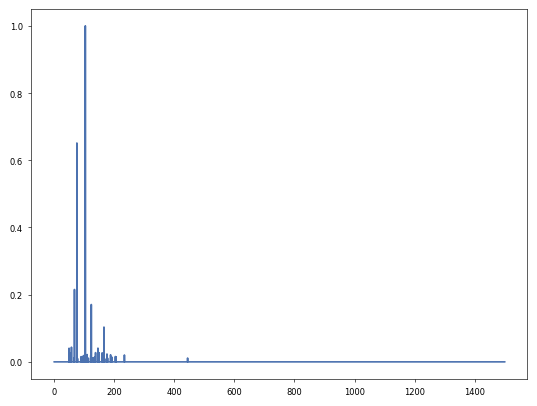

In [73]:
bins = np.linspace(0,1500,15000)
plt.plot(bins, spec_outputs[0])

In [105]:
def inds_to_dense(inds, vals, num_bins=15000, upper_limit=1500):
    """inds_to_dense."""
    dense = np.zeros(num_bins)
    dense[inds] = vals
    return dense

def cos_sim(pred_ar, true_ar):
    """cos_sim."""
    num = np.sum(pred_ar * true_ar, 1)
    denom = np.sqrt(np.sum(pred_ar**2, 1)) * np.sqrt(np.sum(true_ar**2, 1)) + 1e-12
    return num / denom

# Compute the fraction of the true peaks present in the predicted peaks
def frac_true_in_pred(pred_ar, true_ar):
    """frac_true_in_pred."""

    # Check which bins have some >0 value in each 
    num_overlap = ((pred_ar * true_ar) > 0).sum(-1)
    return num_overlap / np.sum(true_ar >0, -1)

out_dicts = []
test_names_set = set(test_names)
test_smis_set = set(test_smiles)
forward_res_folder = Path("../results/2023_05_04_forward_analysis/")
for res_file in forward_res_folder.rglob("*.p"):
    model_name = res_file.parent.stem
    print(model_name)
    # Load res file pickle (keys are 'preds', 'names')
    res = pickle.load(open(res_file, "rb"))

    # Subset to only the preds in test_names
    # note that names is a list
    bool_ar = np.array([n in test_smis_set for n in res["names"]])
    preds = [inds_to_dense(inds=i[0], vals=i[1]) for i in res["preds"]]
    test_preds = np.array(preds)[bool_ar]
    test_smiles = np.array(res["names"])[bool_ar]
    smi_to_preds = dict(zip(test_smiles, test_preds))

    pred_ar = np.vstack([smi_to_preds[name_to_smiles[k]]  for k in test_names])
    true_ar = np.vstack(spec_outputs)

    # Zero all but the top 100 entries in each row
    pred_top = np.zeros_like(pred_ar)
    true_top = np.zeros_like(true_ar)
    for i in range(pred_ar.shape[0]):
        pred_top[i][np.argsort(pred_ar[i])[-100:]] = pred_ar[i][np.argsort(pred_ar[i])[-100:]]
        true_top[i][np.argsort(true_ar[i])[-100:]] = true_ar[i][np.argsort(true_ar[i])[-100:]]
    
    cos_sim_all = cos_sim(pred_top, true_top)
    covg_all = frac_true_in_pred(pred_top, true_top)

    # Compute mean and sem of these and put it in a dict
    cos_sim_mean = cos_sim_all.mean()
    cos_sim_sem = cos_sim_all.std() / np.sqrt(cos_sim_all.shape[0])
    covg_mean = covg_all.mean()
    covg_sem = covg_all.std() / np.sqrt(covg_all.shape[0])

    out_dict = {
        "cos_sim_mean": cos_sim_mean,
        "cos_sim_sem": cos_sim_sem,
        "covg_mean": covg_mean,
        "covg_sem": covg_sem,
        "model": model_name,
    }
    out_dicts.append(out_dict)

no_reverse
no_growing
full_model


In [109]:
out_df = pd.DataFrame(out_dicts)
out_df.to_csv(forward_res_folder / "forward_analysis.tsv", index=False, sep="\t")
out_df

,cos_sim_mean,cos_sim_sem,covg_mean,covg_sem,model
0,0.258297,0.005780,0.515953,0.008845,no_reverse
1,0.350185,0.005835,0.555517,0.008841,no_growing
2,0.383937,0.005591,0.581546,0.008601,full_model
